# Chart Recommender
This file provides an example of running the single chart recommender.     
The input is a CSV file containing the data.     

### Single-Chart Recommender
The output is the recommended charts, described by the column selection and chart type.     

### MV Recommender
The output is the recommended MVs, described as a list of charts.

Notes of limitations:
- A chart can encode a max number of 4 data columns.
- A MV can have a max number of 12 charts.
- The predicted chart type is limited to ('area', 'bar', 'scatter', 'line', 'pie')

In [28]:
import pandas as pd
import json
import numpy as np
import itertools
import sys
import re

import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.nn.functional as nnf

from model.encodingModel import ChartTypeNN, ChartTypeLSTM, ScoreNetLSTM
# from utils.helper import softmax, get_data_feature_by_column, get_embed_feature_by_column, get_all_charts_scores, charts_to_features
from utils import featureExtractor
from utils.ChartRecommender import ChartRecommender

## Load pretrained word-embedding model

In [29]:
word_embedding_model_path = 'utils/en-50d-200000words.vec'

word_embedding_dict = {}
with open(word_embedding_model_path,encoding="utf-8") as file_in:
    lines = []
    for idx, line in enumerate(file_in):
        if idx == 0: ## line 0 is invalid
            continue 
        word, *features = line.split()
        word_embedding_dict[word] = np.array(features)

## Load trained single-chart assessment model and chart type prediction model

In [27]:
# gpu = torch.device('cuda:0')
gpu = torch.device("cpu")

column_score_model = ScoreNetLSTM(input_size=96, seq_length = 4, batch_size=2, pack = True).to(gpu)
column_score_model.load_state_dict(torch.load('trainedModel/singleChartModel.pt', map_location=gpu))
column_score_model.eval()

chart_type_model = ChartTypeLSTM(input_size = 96, hidden_size = 400, seq_length = 4, num_class = 9, bidirectional = True).to(gpu)
chart_type_model.load_state_dict(torch.load('trainedModel/chartType.pt', map_location=gpu))
chart_type_model.eval()

ChartTypeLSTM(
  (lstm): LSTM(96, 400, batch_first=True, bidirectional=True)
  (dense): Sequential(
    (linear0): Linear(in_features=3200, out_features=2000, bias=True)
    (rulu0): LeakyReLU(negative_slope=0.01)
    (dropout0): Dropout(p=0.4, inplace=False)
    (linear1): Linear(in_features=2000, out_features=1600, bias=True)
    (rulu1): LeakyReLU(negative_slope=0.01)
    (dropout1): Dropout(p=0.4, inplace=False)
    (linear2): Linear(in_features=1600, out_features=1200, bias=True)
    (rulu2): LeakyReLU(negative_slope=0.01)
    (dropout2): Dropout(p=0.4, inplace=False)
    (linear4): Linear(in_features=1200, out_features=9, bias=True)
    (output): ReLU()
  )
)

## Single chart recommender
Return a DataFrame:
- indices: the column indices encoded by this chart
- column_selection_score: the predicted score for the column selection. Min-max normed.
- chart type: the chart type ('area', 'bar', 'scatter', 'line', 'pie')
- chart_type_prob: the likelihood that the selected columns are encoded by the chart type
- final_score: the overall score which is column_selection_score * chart_type_prob

In [32]:
chartRecommender = ChartRecommender('csv/penguins.csv', 
                                    word_embedding_dict, column_score_model, chart_type_model,gpu)

In [30]:
chartRecommender.feature_dict

{0: [0.0,
  0.2,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.5136112729101774,
  3.656211353400618,
  1.0,
  0.0058309037900874635,
  0.0,
  1.0,
  1.0,
  0.00872093023255814,
  0.00872093023255814,
  0.4418604651162791,
  0.0,
  0.0,
  0.0,
  0.0,
  0.21818181818181817,
  0.11947356132239798,
  0.0,
  0.0,
  0.00872093023255814,
  1.0,
  1.0,
  1.0,
  0.5972222222222222,
  291.6345387460175,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.4052,
  -0.0952,
  0.1253,
  -0.0547,
  -0.0526,
  -0.4832,
  0.019,
  -0.1569,
  -0.019,
  -0.0552,
  0.1383,
  -0.0254,
  -0.1596,
  -0.0225,
  0.0338,
  -0.0418,
  -0.1241,
  -0.1576,
  -0.0524,
  -0.1153,
  -0.0423,
  0.0885,
  -0.0772,
  -0.0689,
  -0.0303,
  0.0095,
  -0.0884,
  -0.0773,
  0.0313,
  -0.0198,
  -0.0256,
  -0.0474,
  -0.0623,
  -0.018,
  0.0054,
  -0.0276,
  0.0147,
  0.0518,
  0.0497,
  0.0998,
  0.0453,
  -0.0399,
  -0.028,
  0.0458,
  0.0172,
  0.0246,
  0.0275,
  0.0264

In [5]:
## rank the results by the final_score
pd.DataFrame.from_records(chartRecommender.charts).sort_values(by='final_score', ascending = False)

,indices,column_selection_score,chart_type,chart_type_prob,final_score
247,"(1, 3, 6)",1.000000,line,9.999998e-01,1.000000
232,"(1, 2, 6)",0.996297,line,1.000000e+00,0.996297
262,"(1, 5, 6)",0.995994,line,9.999995e-01,0.995994
257,"(1, 4, 6)",0.995900,line,9.999955e-01,0.995896
197,"(0, 3, 6)",0.993849,line,9.999998e-01,0.993849
...,...,...,...,...,...
14,"(2,)",0.000000,scatter,1.628431e-03,0.000000
13,"(2,)",0.000000,pie,9.297263e-15,0.000000
12,"(2,)",0.000000,line,9.983486e-01,0.000000
11,"(2,)",0.000000,bar,9.838510e-06,0.000000


In [6]:
bias=0.000001

scores = pd.DataFrame.from_records(chartRecommender.charts).sort_values(
    by='final_score', ascending=False)
scores["distance"] = 1/(bias+scores["column_selection_score"])
scores


,indices,column_selection_score,chart_type,chart_type_prob,final_score,distance
247,"(1, 3, 6)",1.000000,line,9.999998e-01,1.000000,0.999999
232,"(1, 2, 6)",0.996297,line,1.000000e+00,0.996297,1.003716
262,"(1, 5, 6)",0.995994,line,9.999995e-01,0.995994,1.004021
257,"(1, 4, 6)",0.995900,line,9.999955e-01,0.995896,1.004116
197,"(0, 3, 6)",0.993849,line,9.999998e-01,0.993849,1.006188
...,...,...,...,...,...,...
14,"(2,)",0.000000,scatter,1.628431e-03,0.000000,1000000.000000
13,"(2,)",0.000000,pie,9.297263e-15,0.000000,1000000.000000
12,"(2,)",0.000000,line,9.983486e-01,0.000000,1000000.000000
11,"(2,)",0.000000,bar,9.838510e-06,0.000000,1000000.000000


In [7]:
two_scores=scores.loc[scores["indices"].apply(len)==2]
display(two_scores)

,indices,column_selection_score,chart_type,chart_type_prob,final_score,distance
87,"(1, 6)",0.516812,line,1.000000e+00,5.168116e-01,1.934937
62,"(0, 6)",0.515410,line,1.000000e+00,5.154096e-01,1.940201
37,"(0, 1)",0.512090,line,1.000000e+00,5.120901e-01,1.952778
82,"(1, 5)",0.509304,line,1.000000e+00,5.093041e-01,1.963460
57,"(0, 5)",0.503538,line,1.000000e+00,5.035382e-01,1.985943
...,...,...,...,...,...,...
88,"(1, 6)",0.516812,pie,8.045325e-44,4.157917e-44,1.934937
138,"(5, 6)",0.132948,pie,1.978453e-50,2.630304e-51,7.521709
133,"(4, 6)",0.132629,pie,1.498473e-50,1.987411e-51,7.539771
108,"(2, 6)",0.110141,pie,2.728142e-51,3.004795e-52,9.079215


In [11]:
two_scores["column_selection_score"].min()


0.11014067533419405

In [14]:
src_table = pd.read_csv("csv/penguins.csv")
col_nums=len(src_table.columns)
distance_mtx=np.full((col_nums,col_nums),0)
for index,series in two_scores.iterrows():    
    col_1,col_2=series["indices"]
    distance_mtx[col_1,col_2]=float(series["distance"])
    distance_mtx[col_2, col_1] = float(series["distance"])


<AxesSubplot:>

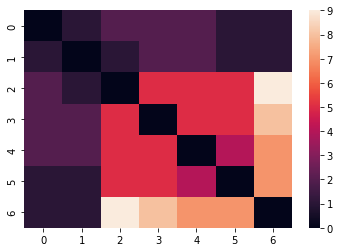

In [15]:
import seaborn as sns

sns.heatmap(distance_mtx)

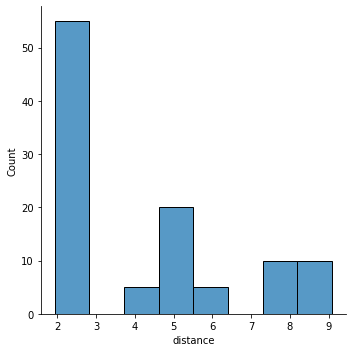

In [18]:
sns.displot(data=two_scores,x="distance")

In [23]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(metric="precomputed",eps=1,min_samples=1).fit(distance_mtx)
clustering.labels_


array([0, 0, 0, 1, 2, 0, 0], dtype=int64)

In [24]:
src_table

,Species,Island,Beak Length (mm),Beak Depth (mm),Flipper Length (mm),Body Mass (g),Sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


## MV Recommender
Return a MV.
- a MV is describled as a list of charts (corresponding to each record in the above charts_df)
- current_mv: optional. 
- max_charts: number of charts in the returned MV

In [6]:
## load model
mv_model = ScoreNetLSTM(input_size=9, seq_length = 12).to(gpu)
mv_model.load_state_dict(torch.load('trainedModel/mvModel.pt', map_location=gpu))
mv_model.eval()

ScoreNetLSTM(
  (lstm): LSTM(9, 200, batch_first=True)
  (linear): Linear(in_features=2400, out_features=1, bias=True)
)

In [7]:
chartRecommender = ChartRecommender('csv/penguins.csv', 
                                    word_embedding_dict, column_score_model, chart_type_model)

In [8]:
## Recommending an MV conditioned on current_mv
current_mv = [{'indices': (1,), 'chart_type': 'pie'}]
chartRecommender.recommend_mv(mv_model, current_mv = current_mv, max_charts = len(current_mv) + 1)

[{'indices': (1,), 'chart_type': 'pie'},
 {'indices': (0, 1, 6),
  'column_selection_score': 0.953993421295783,
  'chart_type': 'bar',
  'chart_type_prob': 0.9747984895572608,
  'final_score': 0.9299513461266928}]

In [9]:
## Recommending an MV without conditions
chartRecommender.recommend_mv(mv_model, current_mv = [], max_charts = 4)

[{'indices': (2, 3, 5),
  'column_selection_score': 0.17087826005069967,
  'chart_type': 'line',
  'chart_type_prob': 0.9999961295181747,
  'final_score': 0.1708775986694998},
 {'indices': (0, 1, 6),
  'column_selection_score': 0.953993421295783,
  'chart_type': 'bar',
  'chart_type_prob': 0.9747984895572608,
  'final_score': 0.9299513461266928},
 {'indices': (2, 4, 5),
  'column_selection_score': 0.17105399002916724,
  'chart_type': 'line',
  'chart_type_prob': 0.9999778765252179,
  'final_score': 0.17105020572053245},
 {'indices': (3, 4, 5),
  'column_selection_score': 0.17125479391300252,
  'chart_type': 'line',
  'chart_type_prob': 0.9998294005573524,
  'final_score': 0.17122557794061022}]